In [50]:
import numpy as np
import pandas as pd
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.sql.functions import col
from pyspark.ml.evaluation import MultilabelClassificationEvaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

#    .config( \
#    "spark.archives",  \
#    "pyspark_venv.tar.gz#environment") \

# Read in full sparkify dataset
feature_data = "./features.json"

df = spark.read.json(feature_data)
df.persist()
df.createOrReplaceTempView('df')
df.head()

Row(adverts_per_song=0.07240704500978473, adverts_per_song_free=0.07240704500978473, adverts_per_song_paid=0.0, artist_diversity=0.7504892367906066, churn=1, downgrade_visits=3, errors_per_activity=0.002277904328018223, friends_added=14, gender='M', help_visits_per_activity=0.006074411541381929, home_visits_per_activity=0.033409263477600606, location='Findlay, OH', mobile=0.0, pc=1.0, skip_ahead_per_song=0.015655577299412915, song_diversity=0.9275929549902152, songs_in_playlist=25, songs_per_artist=1.2359843546284224, submitted_downgrades=1, tablet=0.0, thumbs_down_per_song=0.03228962818003914, thumbs_up_per_song=0.05185909980430528, upgrade_visits=9, userId='1000280')

In [3]:
df.printSchema()

root
 |-- adverts_per_song: double (nullable = true)
 |-- adverts_per_song_free: double (nullable = true)
 |-- adverts_per_song_paid: double (nullable = true)
 |-- artist_diversity: double (nullable = true)
 |-- churn: long (nullable = true)
 |-- downgrade_visits: long (nullable = true)
 |-- errors_per_activity: double (nullable = true)
 |-- friends_added: long (nullable = true)
 |-- gender: string (nullable = true)
 |-- help_visits_per_activity: double (nullable = true)
 |-- home_visits_per_activity: double (nullable = true)
 |-- location: string (nullable = true)
 |-- mobile: double (nullable = true)
 |-- pc: double (nullable = true)
 |-- skip_ahead_per_song: double (nullable = true)
 |-- song_diversity: double (nullable = true)
 |-- songs_in_playlist: long (nullable = true)
 |-- songs_per_artist: double (nullable = true)
 |-- submitted_downgrades: long (nullable = true)
 |-- tablet: double (nullable = true)
 |-- thumbs_down_per_song: double (nullable = true)
 |-- thumbs_up_per_song:

In [4]:
(trainingData, testData) = df.randomSplit([0.75, 0.25])

## DataFrame preparation and scaling

The function display_metrics(prediction) evaluates the prediction dataframe for the typical classifier metrics including the area unter the ROC which is used as a tuning parameter in grid search. It also prints the confusion matrix.

In [30]:
def get_metrics(prediction):
    predictionAndLabels = prediction.withColumn("churnD",col("churn").cast("Double")).select(['prediction', 'churnD']).rdd
    return MulticlassMetrics(predictionAndLabels)

def display_metrics(prediction):
    metrics = get_metrics(prediction)
    evaluator = BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderROC')
    display(metrics.confusionMatrix().toArray())
    print('area under ROC:', evaluator.evaluate(prediction))
    print('    precision: ', metrics.precision(1.0))
    print('       recall: ', metrics.recall(1.0))
    print('     accuracy: ', metrics.accuracy)
    print('           f1: ', metrics.fMeasure(1.0, 1.0)) # label, beta
    ax = sns.heatmap(metrics.confusionMatrix().toArray(), annot=True, fmt='g')
    ax.set(xlabel='Predicted Churn', ylabel='True Churn', title='Confusion Matrix')

The function build_pipeline(classifier, features) gets an instance of the classifier to build into the data preparation pipeline and a list of features to be selected from the dataframe, it returns a Pipeline object.

In [13]:
def build_pipeline(classifier, features):
    stages = [StringIndexer(inputCol=column, outputCol=column+"IDX") for column in ['gender', 'location']]
    onehotencoder = OneHotEncoder(inputCols=["locationIDX"], outputCols=["locationVec"])
    stages.append(onehotencoder)

    assembler = VectorAssembler(
        inputCols=features,
        outputCol="features")

    stages.append(assembler)

    scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')
    stages.append(scaler)
    stages.append(classifier)

    return Pipeline(stages=stages)

CurveMetrics is a class extending the BinaryClassificationMetrics to be able to plot the ROC curve which is implemented in the plot_roc(prediction) function.

In [7]:
# plot the ROC curve, taken from https://itecnote.com/tecnote/pyspark-extract-roc-curve/
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

def plot_roc(prediction):
    preds = prediction.select('churn','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['churn'])))
    points = CurveMetrics(preds).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title('Receiver operating characteristic')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(x_val, y_val)

List of features to be selected from the dataframe for modeling

In [15]:
features = ["adverts_per_song", "adverts_per_song_free", "adverts_per_song_paid", "artist_diversity", "downgrade_visits", "errors_per_activity", "friends_added",  
            "help_visits_per_activity", "home_visits_per_activity", "mobile", "pc", "skip_ahead_per_song", "song_diversity", "songs_in_playlist", "songs_per_artist", "submitted_downgrades", 
            "tablet", "thumbs_down_per_song", "thumbs_up_per_song", "upgrade_visits", "genderIDX"]

## Random Forest Classifier

In [16]:
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaledFeatures")
pipeline = build_pipeline(rf, features)

Lets have a look at the Random Forest Classifier with its default parameters:

array([[4166.,   66.],
       [1108.,  148.]])

area under ROC: 0.7269413996183156
    precision:  0.6915887850467289
       recall:  0.1178343949044586
     accuracy:  0.7860787172011662
           f1:  0.20136054421768707


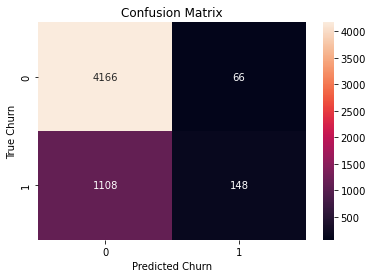

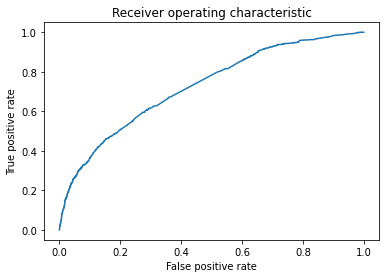

In [32]:
evaluator = BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderROC')
rf_model = pipeline.fit(trainingData)
testPred = rf_model.transform(testData)
testMetrics = get_metrics(testPred)
display_metrics(testPred)
plot_roc(testPred)

The random forest model allows some insights. The feature importance gives us an idea about how the features are taken into account to making the decission

<AxesSubplot:>

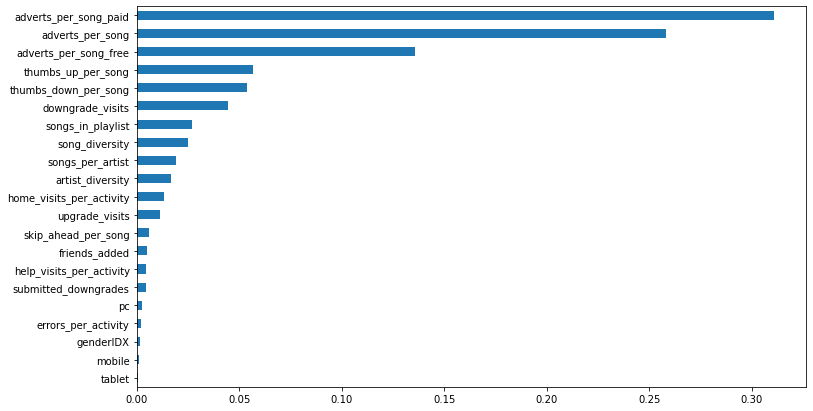

In [29]:
fi = rf_model.stages[-1].featureImportances.toArray()
feature_importance = pd.Series(fi, index=features)
feature_importance.sort_values().plot.barh(figsize=(12,7))

This gives an indication that the number of adverts rolled is playing a big role in predicting churn. Having adverts rolled in paid level might even be a bug which needs to be fixed.

Let's try to improving the random forest by hyperparameter tuning with a grid search:

In [46]:
print(rf_model.stages[-1].explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

In [63]:
rf = RandomForestClassifier(labelCol="churn", featuresCol="scaledFeatures")
pipeline = build_pipeline(rf, features)

paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity, ['entropy', 'gini']) \
    .addGrid(rf.maxDepth, [3, 5, 10]) \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.minInfoGain, [0.0, 0.05]) \
    .addGrid(rf.minInstancesPerNode, [1, 2, 3]) \
    .build()
  
evaluator = BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderROC')

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

rf_model = crossval.fit(trainingData)

In [64]:
print(rf_model.bestModel.stages[-1].explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

array([[12908.,   119.],
       [ 2727.,  1019.]])

area under ROC: 0.8123978696182813
    precision:  0.8954305799648506
       recall:  0.27202349172450613
     accuracy:  0.830322542180886
           f1:  0.41728091728091726


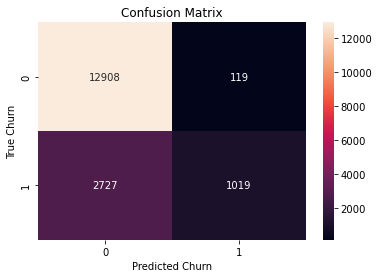

In [65]:
trainPred = rf_model.transform(trainingData)
display_metrics(trainPred)

array([[4086.,  146.],
       [ 983.,  273.]])

area under ROC: 0.7348770325876247
    precision:  0.6515513126491647
       recall:  0.21735668789808918
     accuracy:  0.7942784256559767
           f1:  0.3259701492537314


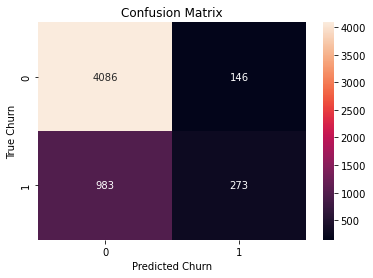

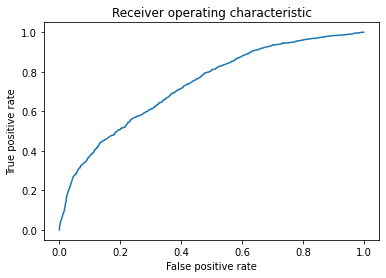

In [66]:
testPred = rf_model.transform(testData)
display_metrics(testPred)
plot_roc(testPred)

## Gradient Boosted Tree

In [44]:
gbt = GBTClassifier(labelCol="churn", featuresCol="scaledFeatures")
gbt_pipeline = build_pipeline(gbt, features)

Let's have a look at the gradient boosted tree classifier with its default parameters first.

/usr/local/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


array([[4088.,  144.],
       [ 964.,  292.]])

area under ROC: 0.7362837961903845
    precision:  0.6697247706422018
       recall:  0.23248407643312102
     accuracy:  0.7981049562682215
           f1:  0.34515366430260047


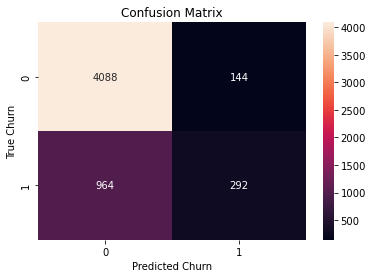

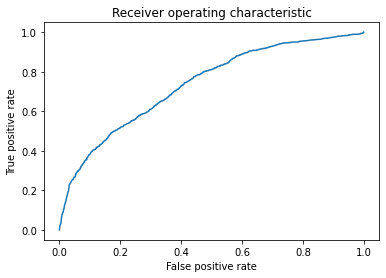

In [45]:
gbt_model = gbt_pipeline.fit(trainingData)
testPred = gbt_model.transform(testData)
testMetrics = get_metrics(testPred)
display_metrics(testPred)
plot_roc(testPred)

In [40]:
print(gbt_model.stages[-1].explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

<AxesSubplot:>

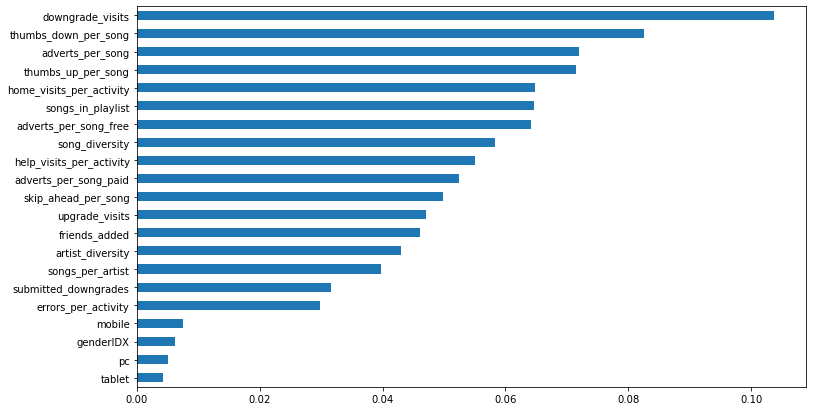

In [43]:
fi = gbt_model.stages[-1].featureImportances.toArray()
feature_importance = pd.Series(fi, index=features)
feature_importance.sort_values().plot.barh(figsize=(12,7))

Let's try to find some better hyperparameters for the gradient boosted trees model

In [71]:
gbt = GBTClassifier(labelCol="churn", featuresCol="scaledFeatures")
gbt_pipeline = build_pipeline(gbt, features)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 10]) \
    .addGrid(gbt.minInfoGain, [0.0, 0.05, 0.1]) \
    .addGrid(gbt.maxIter, [20, 30, 50]) \
    .addGrid(gbt.minInstancesPerNode, [1, 2, 3]) \
    .build()
  
evaluator = BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderROC')

crossval = CrossValidator(estimator=gbt_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)  

gbt_model = crossval.fit(trainingData)

array([[12517.,   510.],
       [ 2925.,   821.]])

area under ROC: 0.7413884756416409
    precision:  0.6168294515401953
       recall:  0.2191671115856914
     accuracy:  0.7952065820067966
           f1:  0.32341934213117984


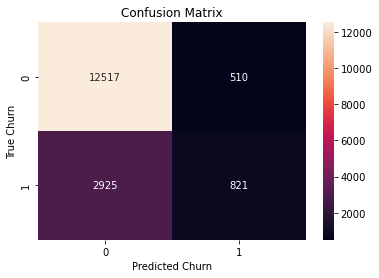

In [72]:
trainPred = gbt_model.transform(trainingData)
display_metrics(trainPred)

array([[4058.,  174.],
       [ 956.,  300.]])

area under ROC: 0.7400128720515812
    precision:  0.6329113924050633
       recall:  0.23885350318471338
     accuracy:  0.7940962099125365
           f1:  0.34682080924855485


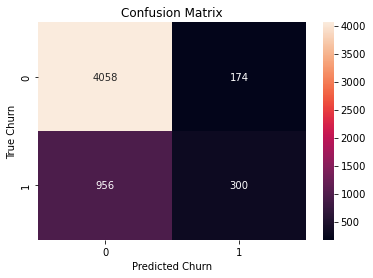

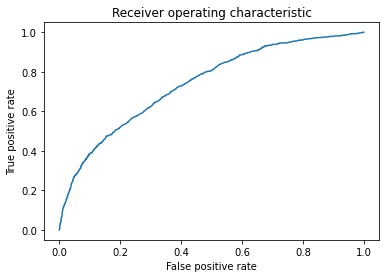

In [74]:
testPred = gbt_model.transform(testData)
display_metrics(testPred)
plot_roc(testPred)

In [75]:
print(gbt_model.bestModel.stages[-1].explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

<AxesSubplot:>

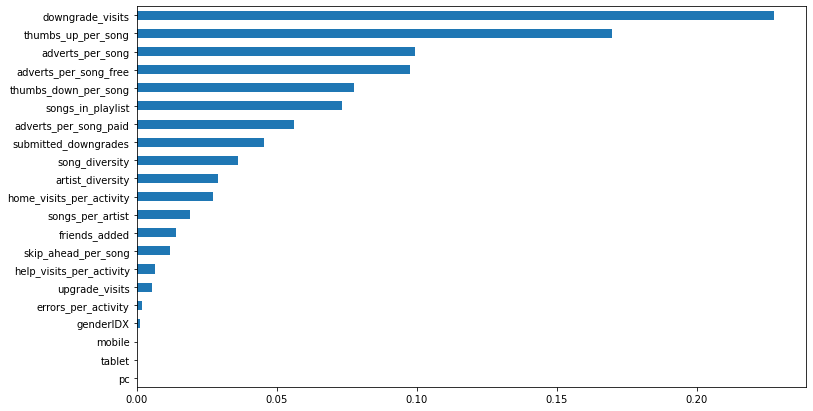

In [76]:
fi = gbt_model.bestModel.stages[-1].featureImportances.toArray()
feature_importance = pd.Series(fi, index=features)
feature_importance.sort_values().plot.barh(figsize=(12,7))

In [77]:
testPred.count()

5488

## Linear Support Vector Machine

In [281]:
svc = LinearSVC(labelCol="churn", featuresCol="scaledFeatures")
pipeline = build_pipeline(svc)


In [287]:
paramGrid = ParamGridBuilder() \
    .addGrid(svc.maxIter, [5, 10, 20, 50]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='churn', metricName='areaUnderROC'),
                          numFolds=5)  

svc_model = crossval.fit(trainingData)

array([[1.295e+04, 1.000e+01],
       [3.696e+03, 2.900e+01]])

precision:  0.7435897435897436
   recall:  0.007785234899328859
 accuracy:  0.777884327240036
       f1:  0.015409139213602551


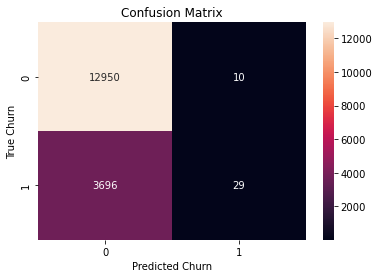

In [288]:
trainPred = svc_model.transform(trainingData)
trainMetrics = get_metrics(trainPred)
display_metrics(trainMetrics)

array([[4.296e+03, 3.000e+00],
       [1.274e+03, 3.000e+00]])

precision:  0.5
   recall:  0.0023492560689115116
 accuracy:  0.7709827833572453
       f1:  0.004676539360872954


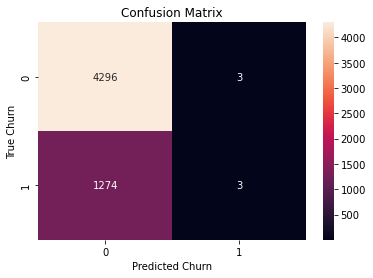

In [289]:
testPred = svc_model.transform(testData)
testMetrics = get_metrics(testPred)
display_metrics(testMetrics)

The linear SVC doesn't perform well so I won't look further into it